# **SIN 393 – Introduction to Computer Vision (2022-2)**

# Lecture 01 - Part 2 - Image classification

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

## Importing the required libraries
---

In [1]:
import os

import numpy as np
from skimage import util, transform, filters, color, measure, morphology
from sklearn import model_selection, neighbors, metrics, preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### %matplotlib notebook
%matplotlib widget

## The dataset 
---
* Flavia leaf dataset:
    * A dataset containing leaf images
    * http://flavia.sourceforge.net/ 
    * 1,907 images
    * 33 classes

### Reduced versions of the Flavia dataset

* Only 3 of the 33 classes (all images in these classes)
    * ```data/flavia```
* Only 6 images in each of the 3 classes
    * ```data/flavia_toy```

In [2]:
# 3 classes - all images in these classes
ds_path = 'data/flavia_toy1'

# 3 classes - 6 images per class
#### ds_path = 'data/flavia_toy2'

In [3]:
print(ds_path)

data/flavia_toy1


## Loading the images from the dataset

In [4]:
# List of all folders in the folder 'ds_path' (classes)
classes_list = os.listdir(ds_path)

# List of all images in the dataset
image_list = []
# Lista of the image labels
label_list = []

# List of the image names
filename_list_ = []

# Iterate along the classes of the dataset
for classe in classes_list:
    
    # Listagem de todas as imagens na pasta daquela classe
    filename_list = os.listdir(os.path.join(ds_path, classe))
    
    # Percorre os arquivos na pasta atual
    for filename in filename_list:
        # Carrega a imagem
        img_temp = plt.imread(os.path.join(ds_path, classe, filename))
        
        # Redimensiona a imagem para 1/4 do tamanho original
        img_temp = transform.resize(img_temp, (img_temp.shape[0]//4, img_temp.shape[1]//4), anti_aliasing=True)
        
        # Adiciona a imagem a lista de imagens
        image_list.append(img_temp)
        # Adiciona o rótulo da imagem à lista de rótulos
        label_list.append(classe)
        # Adiciona o nome da imagem à uma lista (para fins de visualização)
        filename_list_.append(filename)

In [5]:
# Lista com os rótulos das imagens        
print(label_list)

['acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'acer_palmatum', 'aesculus_chinensis', 'aesculus_chinensis', 'ae

### Convertendo os nomes das classes para índices numéricos

In [6]:
# Indices das classes dos objetos do dataset
_, _, label_list_idx = np.unique(label_list, return_index=True, return_inverse=True)

print(type(label_list_idx))
print(label_list_idx)

### label_list_idx = np.array(label_list_idx)

<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]


## Plotting the dataset images
---

* Plotting the N first images for each class.
* Important to start understanding the dataset.

In [7]:
# Seleciona apenas as primeiras N imagens de cada classe
image_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i in range(3):
    # As 6 primeiras ocorrencias em que label é igual a 'i'.
    image_list_temp += [image_list[j] for j in np.where(label_list_idx==i)[0][:6]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list_idx==i)[0][:6]]

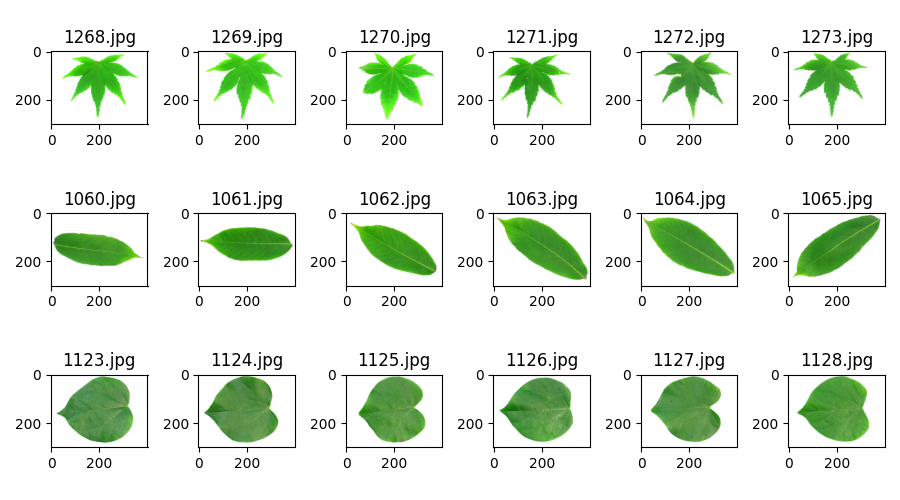

In [8]:
fig, ax  = plt.subplots(3, 6, figsize=(9, 5))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, vmin=0, vmax=255)
    ax[i//6, i%6].set_title(str(filename))
    ### ax[i//6, i%6].axis('off')

fig.tight_layout()
plt.show()

## Extracting some features from images
----
* Vamos extrair algumas caracteristicas de forma dos objetos nas imagens.
    * Área, maior eixo, menor eixo, solidez e ecentricidade.
* Para isso, primeiramente é necessário segmentar as folhas presentes na imagem.
    1. Converter o tipo de dados da imagem para float;
    2. Converter a imagem de RGB para níveis de cinza;
    3. Segmentar a imagem usando o método de Otsu;
    4. Remover artefatos resultantes da segmentação com tamanho menor do que 10.000 pixels.

In [9]:
# Nomes das caracteristicas computadas
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'eccentricity']

In [10]:
# 2D array with the images features
# Each line stores information about an image. Each column stores one feature.
# [ [area, major_axis, minor_axis, solidity, eccentricity] ]
feature_mat = []

# Lista com as imagens segmentadas (binárias)
seg_list = []
# Lista com os rótulos das imagens
list_label = []

for i, (image, label) in enumerate(zip(image_list, label_list)):
    # DEBUG
    print('Imagem {} - classe {}'.format(i, label))
    
    # Adiciona o rótulos (label) da imagem à lista
    list_label.append(label)
    
    # Image segmentation
    # --------------------------------------------------
    # Convert the image data type to float
    img_float = util.img_as_float(image)
    ## print(img_float.shape, img_float.min(), img_float.max())
    
    # Convert to intensity image (gray level)
    img_float = color.rgb2gray(img_float)
    
    # Segmentação por limiarização usando Otsu
    img_seg = img_float < filters.threshold_otsu(img_float)
    ### print(img_seg.shape, img_seg.min(), img_seg.max())
    
    # Remove objetos na imagem com menos de N pixels.
    img_seg = morphology.remove_small_objects(img_seg, 10000)
    
    # Append the segmented image to a list
    seg_list.append(img_seg)
    
    # Generate a label image
    im_lbl = measure.label(img_seg)
    
    # Calcula uma lista de propriedades (caracteristicas) dos objetos na imagem
    props = measure.regionprops(im_lbl)
    ### print(len(props))
    
    if len(props) != 1:
        print(f'ERRO de segmentação: {len(props)}')
        continue

    # Iterate along the computed feartures
    for prop in props:
        # Prop. 0: Area
        area = prop.area
        # Prop. 1: Maior eixo
        major_axis = prop.major_axis_length
        # Prop. 2: Menor eixo
        minor_axis = prop.minor_axis_length 
        # Prop. 3: Solidez
        solidity = prop.solidity 
        # Prop. 4: Excentricidade
        eccentricity = prop.eccentricity 

        # Monta o vetor de caracteristicas deste objeto.
        feature_list = [area, major_axis, minor_axis, solidity, eccentricity]
    
    # Adiciona as caracteristicas desta imagem na matriz de caracteristicas
    feature_mat.append(feature_list)

Imagem 0 - classe acer_palmatum
Imagem 1 - classe acer_palmatum
Imagem 2 - classe acer_palmatum
Imagem 3 - classe acer_palmatum
Imagem 4 - classe acer_palmatum
Imagem 5 - classe acer_palmatum
Imagem 6 - classe acer_palmatum
Imagem 7 - classe acer_palmatum
Imagem 8 - classe acer_palmatum
Imagem 9 - classe acer_palmatum
Imagem 10 - classe acer_palmatum
Imagem 11 - classe acer_palmatum
Imagem 12 - classe acer_palmatum
Imagem 13 - classe acer_palmatum
Imagem 14 - classe acer_palmatum
Imagem 15 - classe acer_palmatum
Imagem 16 - classe acer_palmatum
Imagem 17 - classe acer_palmatum
Imagem 18 - classe acer_palmatum
Imagem 19 - classe acer_palmatum
Imagem 20 - classe acer_palmatum
Imagem 21 - classe acer_palmatum
Imagem 22 - classe acer_palmatum
Imagem 23 - classe acer_palmatum
Imagem 24 - classe acer_palmatum
Imagem 25 - classe acer_palmatum
Imagem 26 - classe acer_palmatum
Imagem 27 - classe acer_palmatum
Imagem 28 - classe acer_palmatum
Imagem 29 - classe acer_palmatum
Imagem 30 - classe a

In [11]:
# Converte a lista de caracteristicas para um arranjo NumPy
feature_mat = np.array(feature_mat)

# Shape of the feature_mat.
# Each row is a sample (image), and each column is a feature.
print(feature_mat.shape)

(191, 5)


In [12]:
# Algumas estatisticas sobre o conjunto de caracteristicas
with np.printoptions(precision=4, suppress=True):
    print(feature_mat.min(0))
    print(feature_mat.max(0))
    print(feature_mat.mean(0))
    print(feature_mat.std(0))

[17632.       186.1457   115.8967     0.4389     0.0952]
[62852.       414.4433   273.5043     0.9846     0.9333]
[42335.4346   290.3432   203.0026     0.8368     0.5644]
[11898.855     63.5739    44.8522     0.2023     0.2619]


### Plotting some segmented images from each class
* Plotando um subconjunto de imagens segmentadas de cada classe

In [13]:
# Seleciona apenas as primeiras N imagens de cada classe
seg_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i in range(3):
    # As 6 primeiras ocorrencias em que label é igual a 'i'.
    seg_list_temp += [seg_list[j] for j in np.where(label_list_idx==i)[0][:6]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list_idx==i)[0][:6]]

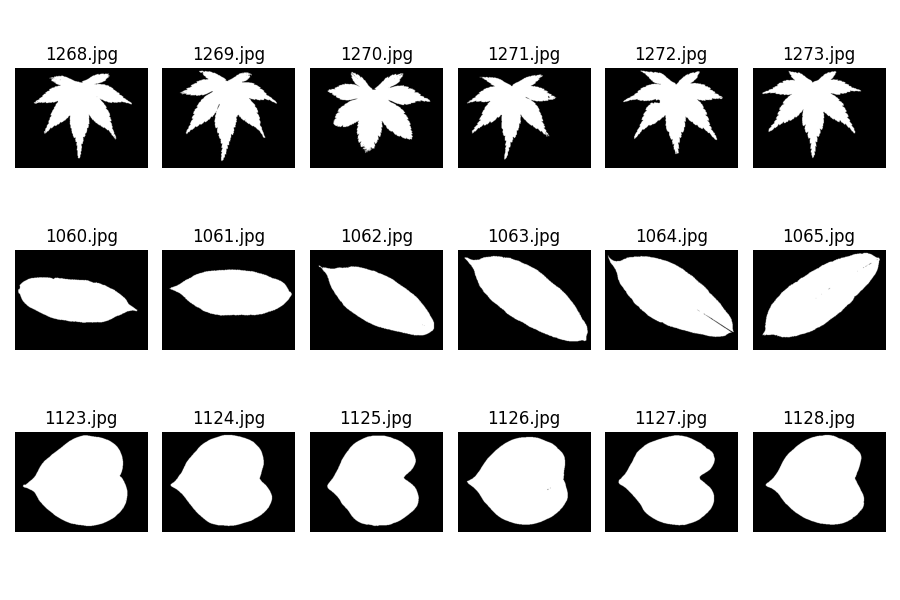

In [14]:
fig, ax  = plt.subplots(3, 6, figsize=(9, 6))

for i, (image, filename) in enumerate(zip(seg_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))
    ax[i//6, i%6].axis('off')
    
fig.tight_layout()
plt.show()

### Plotando as caracteristicas computadas

In [15]:
df = pd.DataFrame(feature_mat, columns=features)

df['class'] = label_list

### print(df)
display(df)

,area,major_axis,minor_axis,solidity,eccentricity,class
0,29335.0,232.175652,199.506366,0.555829,0.511488,acer_palmatum
1,30990.0,233.525495,212.554472,0.545685,0.414173,acer_palmatum
2,35396.0,258.027906,208.486083,0.653135,0.589185,acer_palmatum
3,27018.0,223.482678,195.044617,0.524581,0.488167,acer_palmatum
4,30928.0,244.160662,203.943848,0.525700,0.549817,acer_palmatum
...,...,...,...,...,...,...
186,52762.0,275.851396,249.959329,0.959693,0.422983,cersis_chinensis
187,55364.0,278.685695,255.949680,0.969105,0.395614,cersis_chinensis
188,50414.0,278.638768,236.241707,0.955716,0.530249,cersis_chinensis
189,51698.0,271.726867,246.742366,0.964983,0.418856,cersis_chinensis


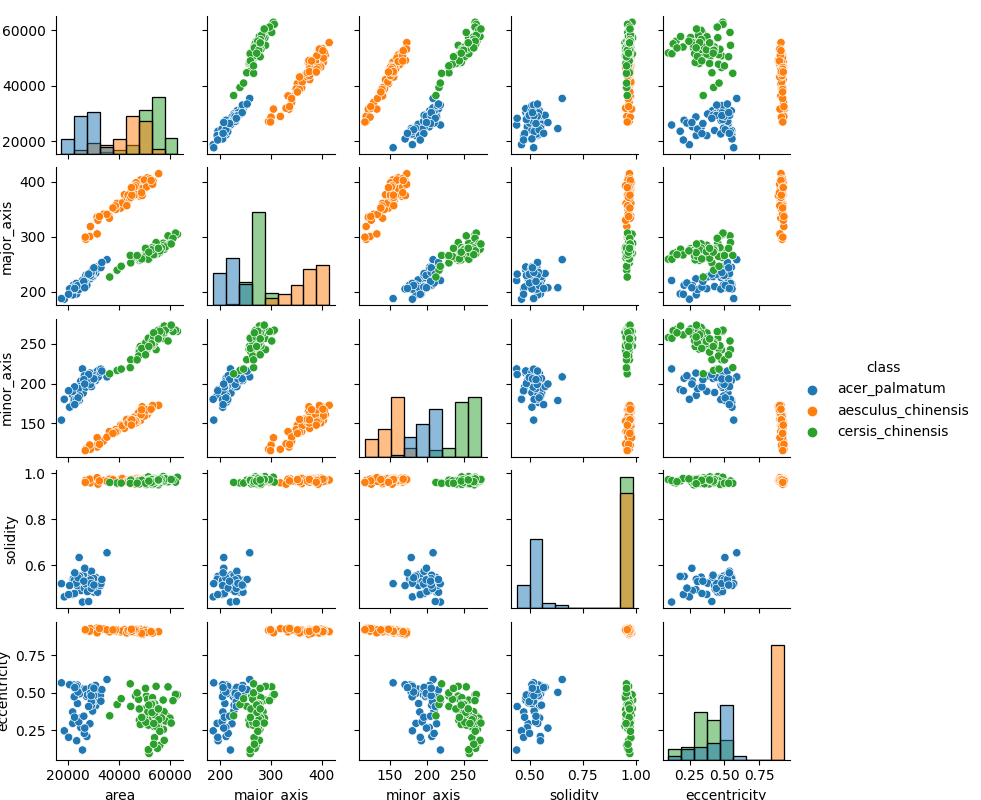

In [16]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Normalizando as caracteristicas
---

* As caracteristicas obtidas podem apresentar faixas de valores muito diferentes. 
    * Isso pode dificultar o treinamento do modelo. 
    * Neste exemplo, a faixa de valores da 'area' vai de 17.644 até 62.862, aproximadamente, já a faixa de valores da circularidade vai de 0,0 até 1,0.
* A normalização transforma as caracteristicas de forma que elas estejam em faixas de valores equivalentes. 
* A ```transformada normal de caracteristicas``` consistem em subtrair a média do conjunto de dados e, em seguida, dividir pelo desvio padrão. 
    * A transformada normal de caracteristicas gera um conjunto de dados com média 0 e desvio padrão 1.

In [17]:
with np.printoptions(precision=4, suppress=True):
    # Média das caracteristicas do conjunto de imagens
    print('Média:')
    print(feature_mat.mean(0))
    # Desvio padrão das caracteroisticas do conjunto de imagens
    print('Desvio padrão:')
    print(feature_mat.std(0))

Média:
[42335.4346   290.3432   203.0026     0.8368     0.5644]
Desvio padrão:
[11898.855     63.5739    44.8522     0.2023     0.2619]


In [18]:
# Transformada Normal de Caracteristicas
feature_mat_norm = (feature_mat - feature_mat.mean(0)) / feature_mat.std(0)

print(feature_mat_norm)

[[-1.09257862 -0.91495965 -0.07795114 -1.38880579 -0.2019375 ]
 [-0.9534896  -0.893727    0.21296208 -1.43895089 -0.57355306]
 [-0.58320187 -0.50831089  0.12225557 -0.90780045  0.09476569]
 [-1.28730323 -1.05169772 -0.17742776 -1.5432751  -0.29099381]
 [-0.95870019 -0.72643877  0.02098446 -1.53774023 -0.05557069]
 [-1.05602048 -0.79569816  0.0133117  -1.58490396 -0.13854706]
 [-1.05501198 -1.0017231   0.15074773 -1.56146376 -0.70843781]
 [-1.00811671 -0.8132081   0.22588777 -1.75235751 -0.43731097]
 [-1.05316306 -0.89822064  0.16067069 -1.68868185 -0.50057291]
 [-1.14409618 -1.0570186   0.22933015 -1.69965171 -1.03279142]
 [-1.24427388 -1.24044141  0.08516341 -1.41558025 -1.35784239]
 [-1.44177188 -1.24772879  0.00603832 -1.71968208 -1.12996499]
 [-1.15392906 -0.99481314 -0.07422817 -1.44011607 -0.33596876]
 [-1.36630243 -1.08901749 -0.33087538 -1.38509456 -0.14963344]
 [-1.55312713 -1.27807614 -0.31528191 -1.61332717 -0.51650233]
 [-1.45715151 -1.29097462 -0.14597489 -1.43089052 -0.88

In [19]:
with np.printoptions(precision=4, suppress=True):
    # Média das caracteristicas do conjunto de imagens
    print('Média:')
    print(feature_mat_norm.mean(0))
    # Desvio padrão das caracteroisticas do conjunto de imagens
    print('Desvio padrão:')
    print(feature_mat_norm.std(0))

Média:
[ 0. -0. -0.  0. -0.]
Desvio padrão:
[1. 1. 1. 1. 1.]


### Plotando as caracteristicas normalizadas

In [20]:
df_norm = pd.DataFrame(feature_mat_norm, columns=features)

df_norm['class'] = label_list
print(df_norm)

         area  major_axis  minor_axis  solidity  eccentricity  \
0   -1.092579   -0.914960   -0.077951 -1.388806     -0.201937   
1   -0.953490   -0.893727    0.212962 -1.438951     -0.573553   
2   -0.583202   -0.508311    0.122256 -0.907800      0.094766   
3   -1.287303   -1.051698   -0.177428 -1.543275     -0.290994   
4   -0.958700   -0.726439    0.020984 -1.537740     -0.055571   
..        ...         ...         ...       ...           ...   
186  0.876266   -0.227952    1.046920  0.607587     -0.539911   
187  1.094943   -0.183370    1.180477  0.654113     -0.644426   
188  0.678936   -0.184108    0.741079  0.587926     -0.130295   
189  0.786846   -0.292830    0.975196  0.633737     -0.555672   
190  1.101414   -0.182763    1.188057  0.658174     -0.654149   

                class  
0       acer_palmatum  
1       acer_palmatum  
2       acer_palmatum  
3       acer_palmatum  
4       acer_palmatum  
..                ...  
186  cersis_chinensis  
187  cersis_chinensis  
188

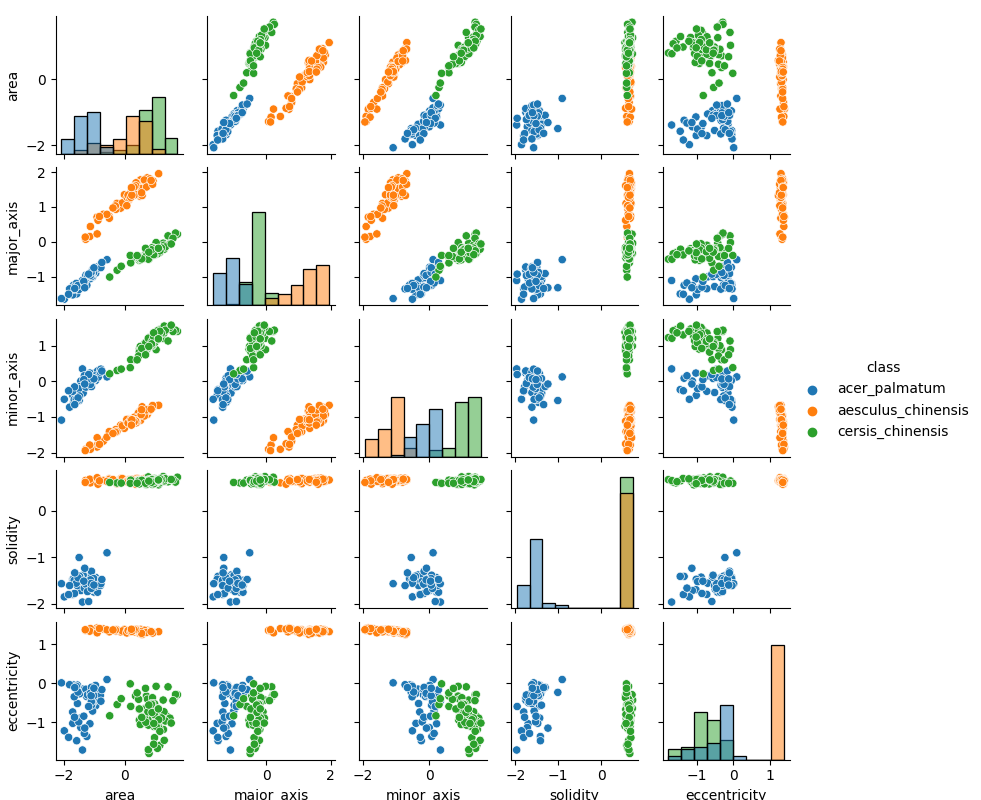

In [21]:
g = sns.PairGrid(df_norm, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## Cross-validation - Hold-out
---

* Separa o conjunto de dados em subconjuntos para treino, validação e testes. 
    * Neste exemplo, por motivos de simplificação, vamos dividir apenas em treino e testes.

In [22]:
# Selecionamos apenas duas caracteristicas: Área e maior-eixo
feature_mat_ok = feature_mat[:,0:2]

In [23]:
# Separa o conjunto de dados em 'feature_mat_ok', de acordo com 'label_list'. 
# 30% das imagens vão para o conjunto de testes.
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_mat_ok, 
                                                                    label_list, 
                                                                    test_size=0.3, 
                                                                    random_state=42)

## Normalizando as características
---

* As características obtidas podem apresentar faixas de valores muito diferentes. 
    * Isso pode dificultar o treinamento do modelo. 
    * Neste exemplo, a faixa de valores da 'area' vai de 17.644 até 62.862, aproximadamente, já a faixa de valores da circularidade vai de 0,0 até 1,0.
* A normalização transforma as características de forma que elas estejam em faixas de valores equivalentes. 
* A ```transformada normal de características``` ou ```Standard Scaler``` consiste em subtrair a média do conjunto de dados e, em seguida, dividir pelo desvio padrão. 
    * A transformada normal de características gera um conjunto de dados com média 0 e desvio padrão 1.
* A normalização **não** deve ser realizada sobre todo o conjunto de dados. 
    * A normalização deve ser realizada **após** a divisão do conjunto para a validação cruzada.
    * O conjunto de testes não deve ser acessado, nem direta nem indiretamente, durante o treinamento ou durante o ajuste de hiperparâmetros. 
    * A normalização do conjunto de treinamento, de validação e de testes deve ser realizado usando a média e o desvio padrão do conjunto de treinamento.

In [24]:
# Média das caracteristicas do conjunto de treinamento
X_train_mean = X_train.mean(0)
# Desvio padrão das caracteristicas do conjunto de treinamento
X_train_std = X_train.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train.mean(0))
    print(X_train.std(0))

[41870.8346   288.7016]
[11396.7965    61.9699]


In [25]:
# Transformada Normal de Caracteristicas
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

with np.printoptions(precision=4, suppress=True):
    print(X_train_norm)
    print(X_test_norm)

[[-2.0299 -1.6549]
 [-1.0661 -0.896 ]
 [-1.3123  0.1661]
 [ 0.5375 -0.4547]
 [-0.5713  0.8358]
 [ 0.3643  1.4015]
 [ 1.2383 -0.2845]
 [-0.5681 -0.495 ]
 [-1.0258 -0.8674]
 [ 0.1093  1.0903]
 [ 0.2466  1.335 ]
 [ 1.1946 -0.2132]
 [-0.8625 -0.7104]
 [ 0.4114  1.6771]
 [-1.5841 -1.2008]
 [ 0.8623 -0.2739]
 [ 0.5376 -0.5163]
 [ 1.2866 -0.1578]
 [-1.4645 -1.2535]
 [ 0.2813  1.3995]
 [ 1.0599 -0.1722]
 [-1.0607 -1.0012]
 [-1.6189 -1.1927]
 [-1.2975  0.1029]
 [-0.9602 -0.7188]
 [-1.8474 -1.3532]
 [ 0.7543  1.685 ]
 [ 0.7719 -0.2047]
 [ 0.7399 -0.3377]
 [ 1.368  -0.1286]
 [-1.2583 -1.2461]
 [ 0.6726 -0.4566]
 [-0.2836  1.081 ]
 [ 0.7814 -0.2014]
 [-1.0999 -0.9122]
 [ 0.5136 -0.399 ]
 [ 0.5699 -0.5   ]
 [-0.0838  1.1355]
 [ 0.8478 -0.3832]
 [ 0.1395  1.3334]
 [-0.796  -0.7049]
 [ 0.267   1.6206]
 [-1.7439 -1.3482]
 [-0.9789 -0.7521]
 [-0.2212 -0.8041]
 [ 0.8436 -0.3134]
 [-1.6901 -1.3601]
 [-1.5103 -1.2339]
 [ 1.1142 -0.2888]
 [ 1.1982  2.0291]
 [-0.2308  1.1572]
 [ 0.1206  1.331 ]
 [-1.1002 -0

## Classifying using K-nearest neighbors
---

In [26]:
# Constrói um classificador do tipo K-NN
# K = 3
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador
pred = clf.predict(X_test_norm)

## Evaluating the model
---

In [27]:
# Acertos
acertos = y_test == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(y_test)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['cersis_chinensis' 'aesculus_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'cersis_chinensis' 'cersis_chinensis' 'cersis_chinensis'
 'cersis_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'acer_palmatum' 'acer_palmatum'
 'acer_palmatum' 'aesculus_chinensis' 'aesculus_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'aesculus_chinensis'
 'acer_palmatum' 'acer_palmatum' 'aesculus_chinensis' 'cersis_chinensis'
 'aesculus_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'cersis_chinensis' 'aesculus_chinensis'
 'cersis_chinensis' 'cersis_chinensis' 'acer_palmatum'
 'aesculus_chinensis' 'acer_palmatum' 'cersis_chinensis'
 'aesculus_chinensis' 'aesculus_chinensis' 'acer_palmatum'
 'cersis_chinensis' 'acer_palmatum' 'cersis_chinensis' 'cersis_chinensis'
 'acer_palmatum' 'cersis_chinen

### Matriz de confusão e o relatório de treinamento

In [28]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_test, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_test, pred))


Matriz de confusão:
[[17  0  0]
 [ 0 19  0]
 [ 0  0 22]]

Relatório de classificação:
                    precision    recall  f1-score   support

     acer_palmatum       1.00      1.00      1.00        17
aesculus_chinensis       1.00      1.00      1.00        19
  cersis_chinensis       1.00      1.00      1.00        22

          accuracy                           1.00        58
         macro avg       1.00      1.00      1.00        58
      weighted avg       1.00      1.00      1.00        58



## Optimizing hyperparameters in the validation set
---
* Não se deve realizar a otimização de hiperparâmetros usando o conjunto de testes.
* Dessa forma, separamos uma parte do conjunto de treinamento para validação.
* Para fazer isso usando o Scikit-learn:
    * Primeiro separamos o conjunte do dados total em teste e treino. 
    * Depois separamos o conjunto de treino em validação e conjunto de testes final. 

* *Exemplo:* 20% para testes, 20% para validação e 60% para treinamento.

```
 +-- Conjunto de dados - 100%
     +-- Conjunto de testes - 20%
     +-- Conjunto de treino 1 - 80%
         +-- Conjunto de validação - 20% do conjunto de dados = 25% do conjunto de treino 1 (0,2 / 0,8 = 0,25)
         +-- Conjunto de treino 2 - 60 % do conjunto de dados = 75% do conjunto de treino 1 (0,8 * 0,75 = 0,6)```

* Entretanto, o exemplo anterior estava muito fácil de resolver, conseguimos acertar 100% dos casos na primeira tentativa.
* Vamos escolher outras caracteristicas, para tornar a tarefa um pouco mais dificil para o nosso classificador.

In [29]:
# Selecionamos apenas duas caracteristicas: Área e solidez
feature_mat_ok = feature_mat[:,[0,3]]

* Vamos melhorar a divisão do conjutno de dados também;
    * Vamsos adotar uma divisão estratificada.
        * A divisão estratificada preserva a proporção entre amostras de cada classe nos conjuntos de treino, validação e testes.

In [31]:
# Separa 20% do conjuto de completo para TESTES. 80% para treinamento 1.
X_train_1, X_test, y_train_1, y_test, file_train_1, file_test = model_selection.train_test_split(feature_mat_ok, 
                                                                                                 label_list, 
                                                                                                 filename_list_,
                                                                                                 test_size=0.2, 
                                                                                                 stratify=label_list,
                                                                                                 random_state=42)

In [32]:
# Separa 25% do conjuto de treinamento 1 para validação.
#   -> Equivale a 20% do conjunto completo. 0,2 / 0,8 = 0,25
X_train_2, X_val, y_train_2, y_val, file_train_2, file_val = model_selection.train_test_split(X_train_1, 
                                                                                              y_train_1, 
                                                                                              file_train_1,
                                                                                              test_size=0.25, 
                                                                                              stratify=y_train_1,
                                                                                              random_state=42)

### Normalizando as caracteristicas
* Obtemos uma estimativa da média e do desvio padrão dos dados a partir do conjunto de treino.

In [33]:
# Média das caracteristicas do conjunto de treinamento
X_train_2_mean = X_train_2.mean(0)

# Desvio padrão das caracteristicas do conjunto de treinamento
X_train_2_std = X_train_2.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train_2.mean(0))
    print(X_train_2.std(0))

[42514.6667     0.834 ]
[12227.2475     0.2037]


* Normalizamos os dados do conjunto de treino, de validação e de testes usando a média e desvio padrão calculados a partir do conjunto de treino.
* Diferente do que foi realizado no último exemplo (hold-out simples com treino e teste apenas) em que normalizamos as caracteristicas manualmente, aqui vamos usar a função disponível no Scikit-learn.

In [34]:
# Transformada Normal de Caracteristicas (Manual)
# ----
# X_train_2_norm = (X_train_2 - X_train_2_mean) / X_train_2_std
# X_val_norm = (X_val - X_train_2_mean) / X_train_2_std
# X_test_norm = (X_test - X_train_2_mean) / X_train_2_std

# Transformada Normal de Caracteristicas (Sklearn)
# ----
scaler = preprocessing.StandardScaler().fit(X_train_2)
with np.printoptions(precision=4, suppress=True):
    print(f'Média:  \t {np.array(scaler.mean_)}')
    print(f'Desv. pad.: \t {np.array(scaler.scale_)}')

Média:  	 [42514.6667     0.834 ]
Desv. pad.: 	 [12227.2475     0.2037]


In [35]:
X_train_2_norm = scaler.transform(X_train_2)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

with np.printoptions(precision=4, suppress=True):
    print(f'Treino: \t {X_train_norm.mean():.4f} ± {X_train_norm.std():.4f}')
    print(f'Validação: \t {X_val_norm.mean():.4f} ± {X_val_norm.std():.4f}')
    print(f'Teste:   \t {X_test_norm.mean():.4f} ± {X_test_norm.std():.4f}')

Treino: 	 -0.0000 ± 1.0000
Validação: 	 0.0010 ± 0.9209
Teste:   	 -0.0036 ± 0.9930


### Otimizando o valor de *k*
* Vamos encontrar o melhor valor de k para o K-means em termos de acurácia.
* Vamos testar os seguintes valores de 'k': 1, 3, 5, 7 e 9.

In [36]:
k_list = [1, 3, 5, 7, 9]

In [37]:
# Lista com as acurácias de traino
acc_train_list = []
# Lista com as acurácias de validação
acc_val_list = []

for k_ in k_list:
    # Constrói um classificador K-NN. K = k_
    clf = neighbors.KNeighborsClassifier(n_neighbors=k_)

    # Treinando o classificador
    clf.fit(X_train_2_norm, y_train_2)

    # Testando o classificador (usando o conjunto de validação)
    pred = clf.predict(X_val_norm)
    acc_val = metrics.accuracy_score(y_val, pred)
    
    acc_val_list.append(acc_val)
    
    # Testando o classificador (usando o conjunto de treino)
    # **** Apenas para comparar com o resultado da validação ****
    pred_train = clf.predict(X_train_2_norm)
    acc_train = metrics.accuracy_score(y_train_2, pred_train)
    
    acc_train_list.append(acc_train)  

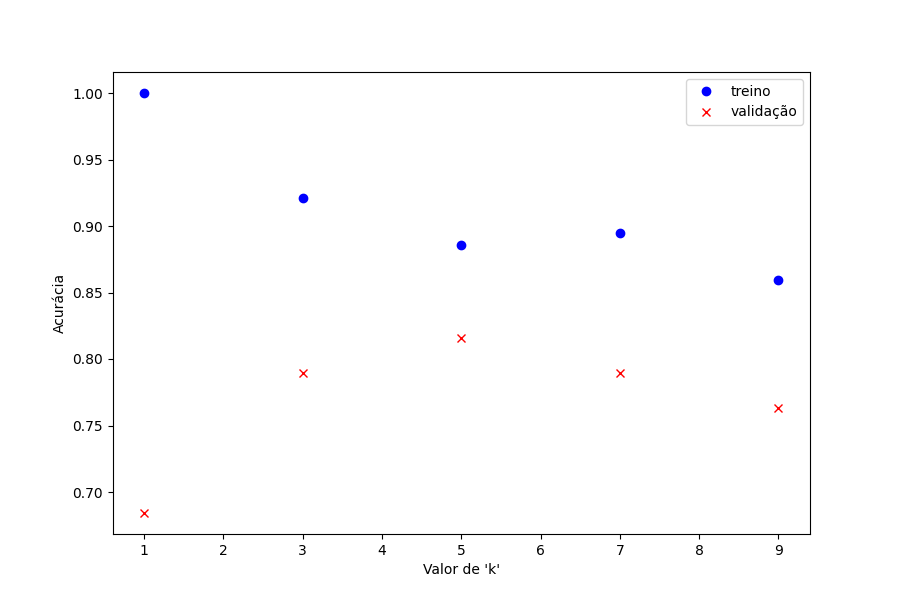

In [38]:
plt.figure(figsize=(9, 6))

plt.plot(k_list, acc_train_list, 'o', color='blue', label='treino')
plt.plot(k_list, acc_val_list, 'x', color='red', label='validação')
plt.xlabel("Valor de 'k'")
plt.ylabel("Acurácia")
plt.legend(loc='best')

plt.show()

In [39]:
print('k \t acc. treino \t acc. val')
print('----------------------------')
for k_, acc_t, acc_v in zip(k_list, acc_train_list, acc_val_list):
    print(f'{k_} \t {acc_t:.4f} \t {acc_v:.4f}')

k_best = k_list[np.argmax(acc_val_list)]
print(f'\nMelhor \'k\': {k_best} ({np.max(acc_val_list):.4f} acc.)')

k 	 acc. treino 	 acc. val
----------------------------
1 	 1.0000 	 0.6842
3 	 0.9211 	 0.7895
5 	 0.8860 	 0.8158
7 	 0.8947 	 0.7895
9 	 0.8596 	 0.7632

Melhor 'k': 5 (0.8158 acc.)


### Testando o melhor modelo com o conjunto de testes

In [40]:
# Constrói um classificador K-NN. K = k_best
clf = neighbors.KNeighborsClassifier(n_neighbors=k_best)

# Treinando o classificador
clf.fit(X_train_2_norm, y_train_2)

# Testando o classificador (usando o conjunto de TESTES)
pred = clf.predict(X_test_norm)
acc_val = metrics.accuracy_score(y_test, pred)

* Matriz de confusão e relatório de classificação

In [41]:
print('\nConfusion matrix:')
print(metrics.confusion_matrix(y_test, pred))

print('\nClassification report:')
print(metrics.classification_report(y_test, pred))


Confusion matrix:
[[11  0  0]
 [ 0 11  2]
 [ 0  5 10]]

Classification report:
                    precision    recall  f1-score   support

     acer_palmatum       1.00      1.00      1.00        11
aesculus_chinensis       0.69      0.85      0.76        13
  cersis_chinensis       0.83      0.67      0.74        15

          accuracy                           0.82        39
         macro avg       0.84      0.84      0.83        39
      weighted avg       0.83      0.82      0.82        39



### A detailed classification report

In [44]:
for i, (y_test_, pred_, filename_) in enumerate(zip(y_test, pred, file_test)):
    print(f'{i} \t {filename_} \t {y_test_} \t {pred_} \t {(y_test_ == pred_)}')

0 	 1061.jpg 	 aesculus_chinensis 	 aesculus_chinensis 	 True
1 	 1323.jpg 	 acer_palmatum 	 acer_palmatum 	 True
2 	 1310.jpg 	 acer_palmatum 	 acer_palmatum 	 True
3 	 1063.jpg 	 aesculus_chinensis 	 aesculus_chinensis 	 True
4 	 1288.jpg 	 acer_palmatum 	 acer_palmatum 	 True
5 	 1150.jpg 	 cersis_chinensis 	 aesculus_chinensis 	 False
6 	 1166.jpg 	 cersis_chinensis 	 aesculus_chinensis 	 False
7 	 1296.jpg 	 acer_palmatum 	 acer_palmatum 	 True
8 	 1095.jpg 	 aesculus_chinensis 	 aesculus_chinensis 	 True
9 	 1159.jpg 	 cersis_chinensis 	 cersis_chinensis 	 True
10 	 1162.jpg 	 cersis_chinensis 	 cersis_chinensis 	 True
11 	 1184.jpg 	 cersis_chinensis 	 aesculus_chinensis 	 False
12 	 1076.jpg 	 aesculus_chinensis 	 cersis_chinensis 	 False
13 	 1156.jpg 	 cersis_chinensis 	 cersis_chinensis 	 True
14 	 1306.jpg 	 acer_palmatum 	 acer_palmatum 	 True
15 	 1094.jpg 	 aesculus_chinensis 	 aesculus_chinensis 	 True
16 	 1290.jpg 	 acer_palmatum 	 acer_palmatum 	 True
17 	 1109.jpg 	

## Bibliography
---
* GONZALEZ, R.C.; WOODS, R.E. **Digital Image Processing.** 3rd ed. Pearson, 2007.
* COSTA, L. DA F.; CESAR-JR., R. M. **Shape analysis and classification: theory and practice.** CRC Press, 2000. Chapter 8.
* Scikit-image documentation.
    * https://scikit-image.org/docs/stable/
* scikit-learn - User Guide.
    * https://scikit-learn.org/stable/user_guide.html